# Flow distortion from the ships super structure

In [ ]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
from matplotlib.ticker import MaxNLocator
import geomag
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
from scipy import stats

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24


def fix_xticks(ax,ds):
    
    if (ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 1 :
        ax[0].xaxis.set_minor_locator(mdates.HourLocator())
        ax[0].xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,3)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        #ax[3].set_xlabel(f"{ds.time[0].values.astype('datetime64[D]')}",loc='left')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 1) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 6) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 14) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 31):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 30):
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    
    rot_ticks(ax[-1],0,'center')



wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'
sc = 'goldenrod'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load the data

In [1]:
ship = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche.nc')
var_to_save = ['AT', 'BP', 'RH', 'RT', 'TW', 'TI', 'ST', 'TT', 'TC', 'SA', 'SH', 'RH_2', 'RT_2', 'TW_2', 'TI_2', 'TT_2', 'TC_2', 'SA_2', 'SW', 'LW', 'LA', 'LO','hrw']
ship = ship[var_to_save]

In [2]:
era5 = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/ERA5_QUICCHE.nc').mean('expver',keep_attrs=True)

era5['t2m'].values = era5['t2m'].values - 273.15
era5['sst'].values = era5['sst'].values - 273.15
era5['skt'].values = era5['skt'].values - 273.15

In [3]:
def correct_wind_speed(ds, var, z):
    
    """
    Corrects wind speed measurements based on the height difference between measurement height (Z_m)
    and reference height (Z).

    Parameters:
    - ds (xarray.Dataset): Dataset containing the wind speed variable.
    - var (str): Name of the wind speed variable in the dataset.
    - z (float): Measurement height (Z_m) in meters.

    Returns:
    - corrected_wind_speed (xarray.DataArray): Wind speed corrected for the height difference.

    """

    # Extract wind speed data from the dataset
    U_Zm = ds[var].values

    # Define reference heights
    Z = 10
    Z_m = z

    # Define roughness length
    Z_0 = 1.52 * 1e-4

    # Apply the correction formula
    corrected_wind_speed = U_Zm * (np.log(Z / Z_0)) / (np.log(Z_m / Z_0))

    return corrected_wind_speed

In [4]:
ship['ws10'] = ('time'), correct_wind_speed(ship,'TW',17)

## Resample to same grid

In [32]:
def angle_diff(ds,var1,var2):
    return np.angle(np.exp(1j * np.deg2rad(ds[var1])) / np.exp(1j * np.deg2rad(ds[var2].values)), deg=True)

In [5]:
########## Ship ##########
ship_1h = ship.reset_coords().resample(time='1h').mean('time')
ship_1h = ship_1h.where(np.isfinite(ship_1h['TW']),drop=True)
t = ship_1h.time.values

lat_pp = (np.round(ship_1h['LA'].interpolate_na('time') * 4) / 4)
lon_pp = (np.round(ship_1h['LO'].interpolate_na('time') * 4) / 4)

   
temp = []
for i in range(len(t)):
    temp.append(era5.sel(time=t[i]).sel(longitude=lon_pp[i]).sel(latitude=lat_pp[i]))
    
era5_ship = xr.concat(temp,dim='time')
era5_ship['wind_speed'] = np.sqrt(era5_ship['u10']**2 + era5_ship['v10']**2)
era5_ship['wind_dir'] = ('time'), ((np.arctan2(era5_ship['u10'],era5_ship['v10']) * 180 / np.pi + 180) % 360).values
era5_ship['doy'] = ship_1h['doy']
era5_ship = era5_ship.set_coords('doy')
ship_1h = ship_1h.set_coords('doy')
#ship_1h['hrw'] = ('time'),angle_diff(ship_1h,'SH','TI')

## Boxplot RSE and correlation with ERA5

### Correlation with ERA5 wind speed

In [35]:
def plot_box_and_corr(shipvar,eravar,ax,units,ymax,angle=False,title=True,xlabel=True):
    
    # Interval for binning the data
    da = 15
    n = []  # List to store the number of data points in each interval
    n_low = []  # List to store the number of data points in each interval
    n_high = []  # List to store the number of data points in each interval
    R = []  # List to store the correlation coefficients
    
    # Create additional axes
    right_ax = ax.twinx()  # Right y-axis

    if title == True:
        ax_title = f'Correlation between ship and ERA5, binned {da} degrees relative wind direction'
    else: 
        ax_title = ''
        
    if xlabel == True:
        x_label = 'Wind direction relative to ship heading (degrees)'
    else: 
        x_label = ''
     
    
    
    # Iterate over the interval of 0 to 180 (inclusive) with step size da
    for i in np.arange(0, 181-da, da):
        # Create a mask to select data within the current interval
        mask  = (np.abs(ship_1h['hrw']) > i) & (np.abs(ship_1h['hrw']) < i + da)
        mask_low  = (np.abs(ship_1h['hrw']) > i) & (np.abs(ship_1h['hrw']) < i + da) & (ship_1h['ws10'] <= 8)
        mask_high = (np.abs(ship_1h['hrw']) > i) & (np.abs(ship_1h['hrw']) < i + da) & (ship_1h['ws10'] > 8)

        # Count the number of data points in the current interval
        m = mask.sum().values
        m_low = mask_low.sum().values
        m_high = mask_high.sum().values
        n.append(m)
        n_low.append(m_low)
        n_high.append(m_high)

        # Generate random values for x-coordinate jittering of scatter plot
        rand_low = np.random.rand(m_low)
        rand_high = np.random.rand(m_high)

        # Apply the mask to select the relevant data for the boxplot
        if angle == False:
            ship_data_low = np.sqrt((np.square(ship_1h.where(mask_low, drop=True)[shipvar] - era5_ship.where(mask_low, drop=True)[eravar])))
            ship_data_high = np.sqrt((np.square(ship_1h.where(mask_high, drop=True)[shipvar] - era5_ship.where(mask_high, drop=True)[eravar])))
        else:
            ship_data_low = np.sqrt((np.square(np.angle(np.exp(1j * np.deg2rad(ship_1h.where(mask_low, drop=True)[shipvar])) / np.exp(1j * np.deg2rad(era5_ship.where(mask_low, drop=True)[eravar].values)), deg=True))))
            ship_data_high = np.sqrt((np.square(np.angle(np.exp(1j * np.deg2rad(ship_1h.where(mask_high, drop=True)[shipvar])) / np.exp(1j * np.deg2rad(era5_ship.where(mask_high, drop=True)[eravar].values)), deg=True))))

            
        # Calculate the correlation coefficient
        _, _, r, _, _ = stats.linregress(ship_1h.where(mask, drop=True)[shipvar], era5_ship.where(mask, drop=True)[eravar])

        R.append(r ** 2)

        # Create the boxplot using the selected data and position
        position = [i]
        ax.boxplot(ship_data_low, positions=[position[0] + 3*da/8], widths=3, medianprops={'color': kc,'lw':3,'ls':'-'},zorder=2)
        ax.boxplot(ship_data_high, positions=[position[0] + 5*da/8], widths=3, medianprops={'color': ppc,'lw':3,'ls':'-'},zorder=2)

    # Customize xticks and labels for the bottom axis
    xticks = np.arange(0, 181, da)
    xtick_labels = [str(x) for x in xticks]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set(xlabel= x_label, ylabel=f'RSE ({units})', ylim=(0, ymax), xlim=(0,180))
    ax.axhline(0, ls='--', c='k', zorder=2)

    # Customize xticks and labels for the top axis
    xticks = np.arange(da/2, 181, da)
    xtick_labels = [str(x) for x in n]

    if title == True:
        
        top_ax = ax.twiny()  # Top x-axis
        top_ax.set_xlim(ax.get_xlim())
        top_ax.set_xticks(xticks)
        top_ax.set_xticklabels(xtick_labels)
        top_ax.set_xlabel('Data points', labelpad=15)

    # Set color and plot the correlation values
    c = "goldenrod"
    right_ax.plot(np.arange(da/2, 181, da), R, c=c, marker='.', ms=20, lw=2, zorder=1)
    right_ax.set(ylim=(0, 1), title=ax_title,xlim=(0,180))
    right_ax.tick_params(axis='y', colors=c)
    right_ax.set_ylabel('Correlation Ship and ERA5', color=c)
    right_ax.spines['right'].set_color(c)

    # # Remove left spines from additional axes
    # top_ax.spines['left'].set_visible(False)
    # right_ax.spines['left'].set_visible(False)

    # right_ax.axhline(0, ls='--', c='k')

    # Add gridlines
    ax.grid(zorder=1)

    # Add colorbar
    # cbar = plt.colorbar(sct, ax=right_ax, label='Wind speed (m s$^{-1}$)',pad=0.075)

    y_limits = ax.get_ylim()
    ax.fill([0, 150, 150, 0, 0], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='mediumseagreen', alpha=0.2)
    ax.fill([150, 180, 180, 150, 150], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='tomato', alpha=0.2)
    ax.axvline(150,c='k',ls='--',lw=3)

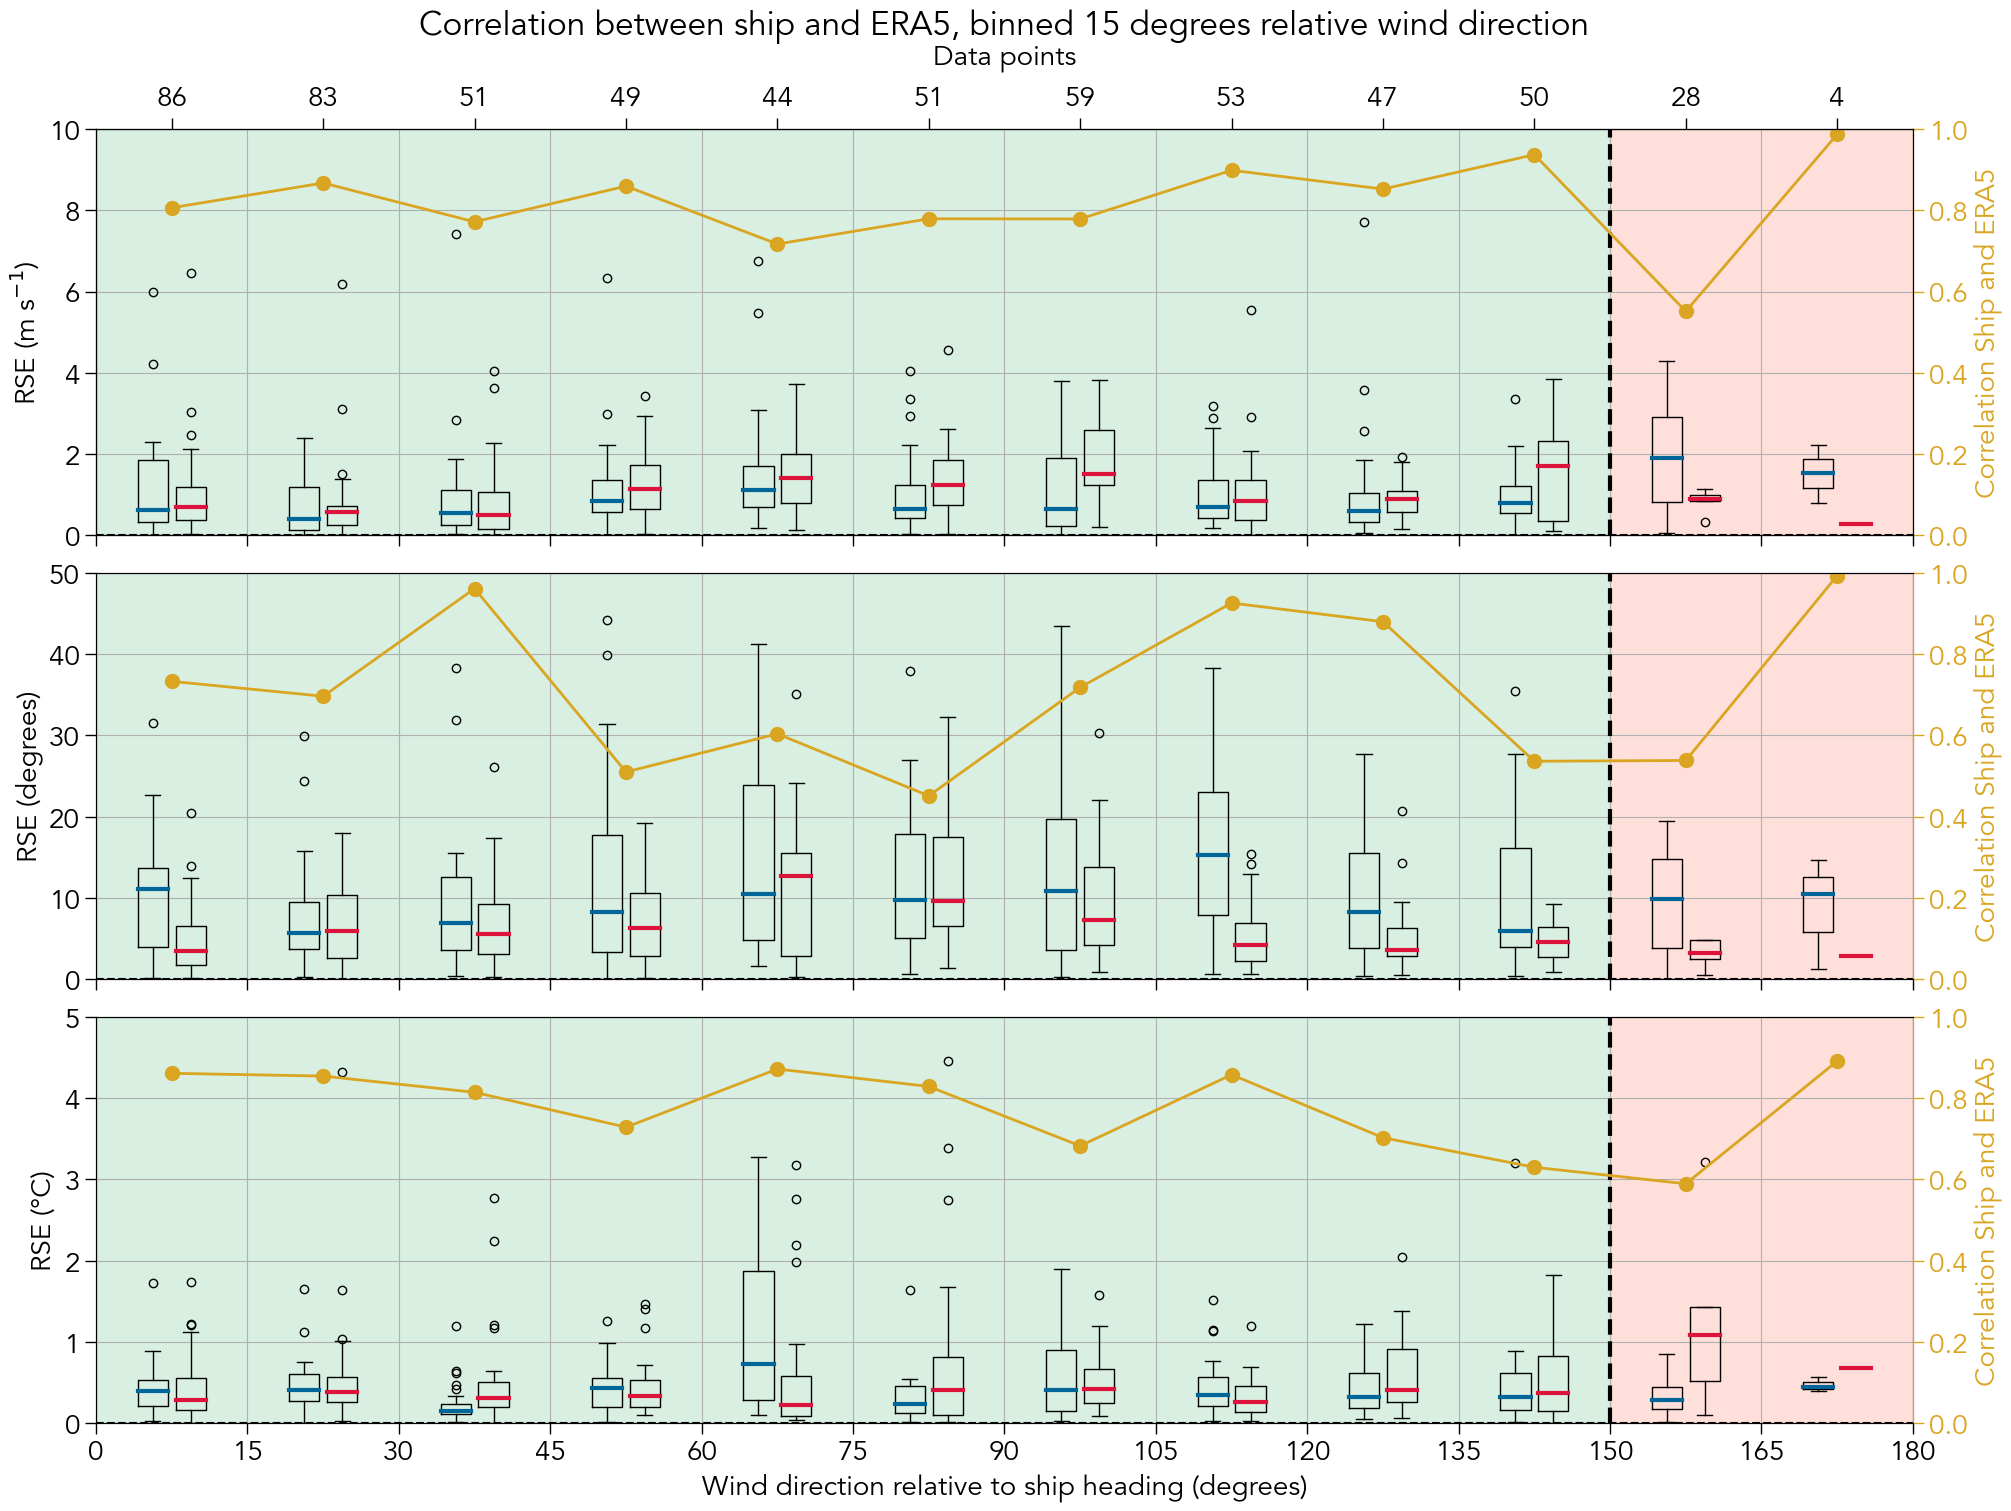

In [36]:
# Create the figure and axes
fig, (ax,bx,cx) = plt.subplots(3,1,figsize=(20, 15),sharex=True,constrained_layout=True)

plot_box_and_corr('ws10','wind_speed',ax,"m s$^{-1}$",10,angle=False,title=True,xlabel=False)
plot_box_and_corr('TI','wind_dir',bx,"degrees",50,angle=True,title=False,xlabel=False)
plot_box_and_corr('RT_2','t2m',cx,"°C",5,angle=False,title=False,xlabel=True)

We can conclude that the Revelle is fairly well constructed, and the bow mast does not distort the wind field too much. There is a drop off after 150°, which is expected considering that the ship's super structure is in the way.